In [1]:
# Library Declaration
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.metrics import confusion_matrix
from collections import defaultdict

In [2]:
# Library Declaration
import numpy as np
import pandas as pd
# Data Input
dataset = pd.read_table('wine.data', sep=',', names=["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium","Total phenols", "Flavanoids", "Nonflavanoid phenols","Proanthocyanins","Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline" ])
samples_per_class = 40
selected_samples = pd.DataFrame()
# print(df)
# print(df.info())
# print(df.shape)

In [3]:
# Iterate over each class
for class_label in dataset['Class'].unique():
    # Get the first 40 samples of the current class
    class_samples = dataset[dataset['Class'] == class_label].head(samples_per_class)
    # Append these samples to the selected_samples DataFrame
    selected_samples = pd.concat([selected_samples, class_samples], ignore_index=True)

# 'selected_samples' now contains the first 40 samples from each class

In [4]:
selected_samples

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,3,13.73,4.36,2.26,22.5,88,1.28,0.47,0.52,1.15,6.62,0.78,1.75,520
116,3,13.45,3.70,2.60,23.0,111,1.70,0.92,0.43,1.46,10.68,0.85,1.56,695
117,3,12.82,3.37,2.30,19.5,88,1.48,0.66,0.40,0.97,10.26,0.72,1.75,685
118,3,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750


In [5]:
# Data Preparing
Y = np.array(selected_samples['Class'])
X_data = np.array(selected_samples.drop('Class', axis=1))

In [6]:
y=Y-1

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Compute the mean and standard deviation based on the training data
X = scaler.fit_transform(X_data)

In [8]:
# 1. Implement the `softmax` function
def softmax(logits):
    exp_shifted = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    softmax_probs = exp_shifted / np.sum(exp_shifted, axis=-1, keepdims=True)
    return softmax_probs

In [9]:
# 2. Implement the `kfold_split` function
def kfold_split(n_samples, n_folds):
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_folds, n_samples // n_folds, dtype=np.int)
    fold_sizes[:n_samples % n_folds] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop
    return folds

In [10]:

# 3. Implement the `accuracy` function
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = y_true.shape[0]
    return correct_predictions / total_predictions

In [11]:
# 4. Implement the `confusion_matrix` function
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=np.int)
    for t, p in zip(y_true, y_pred):
        matrix[t, p] += 1
    return matrix

In [12]:
# Task 3: Main Loops

# SGD with mini-batch
def mini_batch_sgd(X, y, learning_rate, epochs, batch_sizes, num_folds, num_classes, regularization_param):
    n_samples, n_features = X.shape
    k_folds = kfold_split(n_samples, num_folds)

    # Initializing the dictionaries for all batch sizes
    train_accuracies = {batch_size: [] for batch_size in batch_sizes}
    test_accuracies = {batch_size: [] for batch_size in batch_sizes}
    times = {batch_size: [] for batch_size in batch_sizes}
    final_confusion_matrices = {batch_size: np.zeros((num_classes, num_classes), dtype=np.int) for batch_size in batch_sizes}

    for fold in range(num_folds):
        train_indices = np.hstack([k_folds[i] for i in range(num_folds) if i != fold])
        test_indices = k_folds[fold]

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        for batch_size in batch_sizes:  # Iterate over each batch size
            W = np.zeros((n_features, num_classes))

            for epoch in range(epochs):
                epoch_start_time = time.time()

                # Shuffle training data
                permutation = np.random.permutation(len(train_indices))
                X_train_shuffled = X_train[permutation]
                y_train_shuffled = y_train[permutation]

                # Mini-batch processing
                for i in range(0, len(train_indices), batch_size):
                    X_batch = X_train_shuffled[i:i+batch_size]
                    y_batch = y_train_shuffled[i:i+batch_size]

                    # Compute the predictions
                    logits = X_batch.dot(W)
                    probs = softmax(logits)

                    # Compute gradients (using one-hot encoding for the labels)
                    y_batch_one_hot = np.eye(num_classes)[y_batch]
                    gradients = -np.dot(X_batch.T, (y_batch_one_hot - probs)) / X_batch.shape[0]

                    # Update weights
                    W -= learning_rate * (gradients + regularization_param * W)

                epoch_end_time = time.time()
                epoch_time = epoch_end_time - epoch_start_time
                times[batch_size].append(epoch_time)

                # Compute accuracy for current epoch
                logits_train = X_train.dot(W)
                predictions_train = np.argmax(logits_train, axis=1)
                train_acc = accuracy(y_train, predictions_train)
                train_accuracies[batch_size].append(train_acc)

                logits_test = X_test.dot(W)
                predictions_test = np.argmax(logits_test, axis=1)
                test_acc = accuracy(y_test, predictions_test)
                test_accuracies[batch_size].append(test_acc)

                if epoch == epochs - 1:
                    final_confusion_matrices[batch_size] += confusion_matrix(y_test, predictions_test, num_classes)

    return train_accuracies, test_accuracies, times, final_confusion_matrices

In [13]:
# Task 6: Result Visualization
def plot_results(train_accuracies, test_accuracies, times, final_confusion_matrices, batch_sizes, epochs, num_classes):
    # Plot training and testing accuracy for each batch size
    plt.figure(figsize=(14, 7))
    for batch_size in batch_sizes:
        epoch_count = min(len(train_accuracies[batch_size]), epochs)  # Safeguard against data size mismatch
        plt.plot(range(epoch_count), train_accuracies[batch_size][:epoch_count], label=f'Train (batch={batch_size})')
        plt.plot(range(epoch_count), test_accuracies[batch_size][:epoch_count], '--', label=f'Test (batch={batch_size})')
    plt.xlabel('Epoch Index')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy vs Epoch Index for Different Mini-Batch Sizes')
    plt.legend()
    plt.show()

    # Plot training times for each batch size
    plt.figure(figsize=(14, 7))
    for batch_size in batch_sizes:
        epoch_count = min(len(times[batch_size]), epochs)  # Safeguard against data size mismatch
        plt.plot(range(epoch_count), times[batch_size][:epoch_count], label=f'Batch Size {batch_size}')
    plt.xlabel('Epoch Index')
    plt.ylabel('Time (seconds)')
    plt.title('Training Times vs Epoch Index for Different Mini-Batch Sizes')
    plt.legend()
    plt.show()

    # Plot final confusion matrix for each batch size
    for batch_size in batch_sizes:
        plt.figure(figsize=(6, 6))
        cm = final_confusion_matrices[batch_size]
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix (batch={batch_size})')
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, tick_marks)
        plt.yticks(tick_marks, tick_marks)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # Annotate confusion matrix with the counts
        for i in range(num_classes):
            for j in range(num_classes):
                plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

        plt.tight_layout()
        plt.show()

In [14]:

# Define hyperparameters from input
learning_rate = 0.001
epochs = 100
batch_sizes = [10,40,100]
num_folds = 20
num_classes = np.unique(y).size  # Assuming y is the array of labels
regularization_param = 0.01  # Even if it's zero, we're now passing it explicitly

train_accuracies, test_accuracies, times, final_confusion_matrices = mini_batch_sgd(
    X, y, learning_rate, epochs, batch_sizes, num_folds, num_classes, regularization_param
)



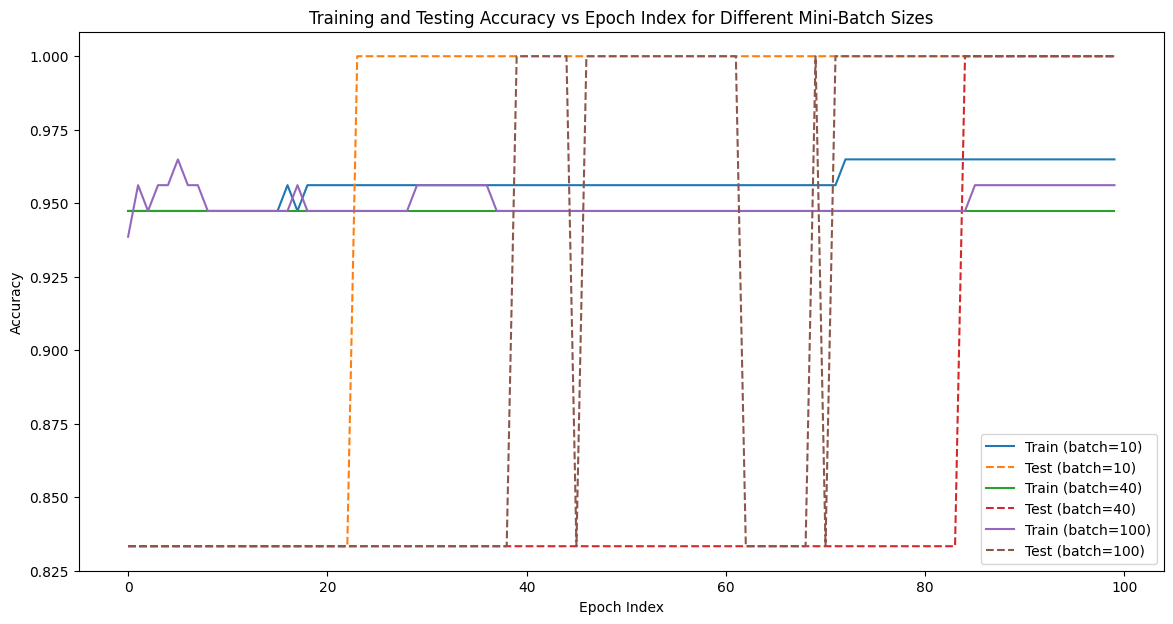

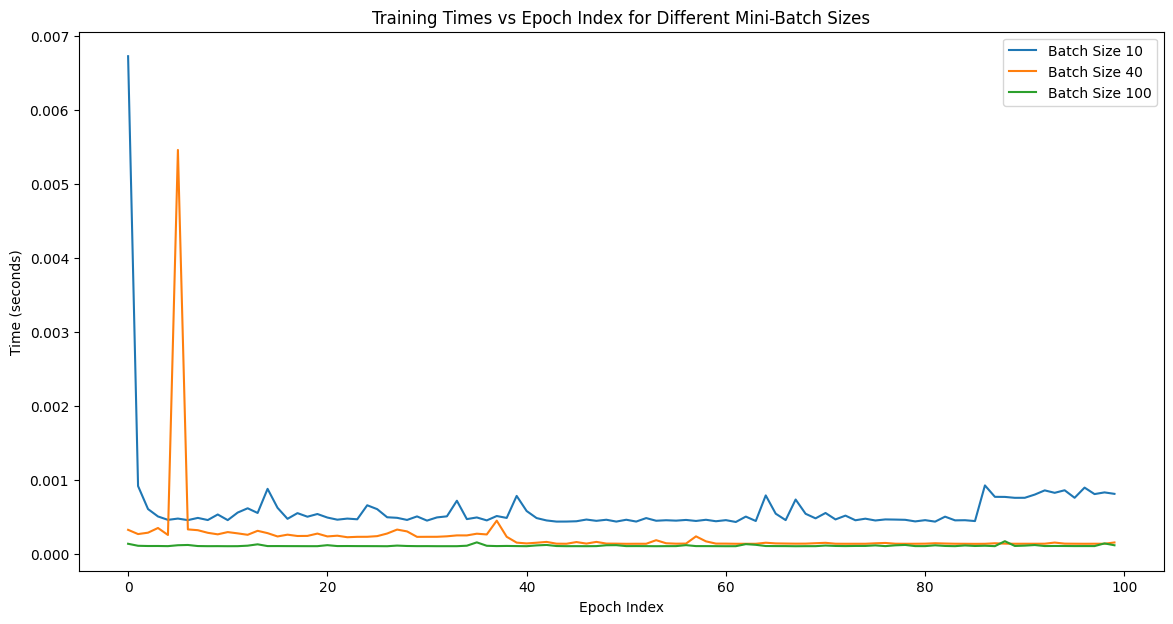

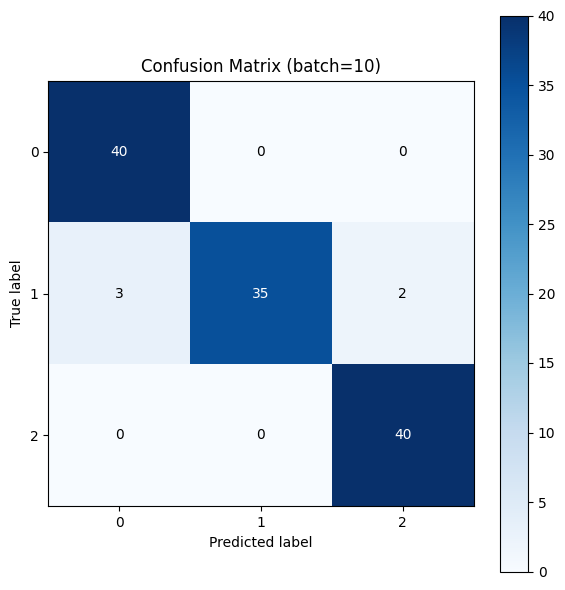

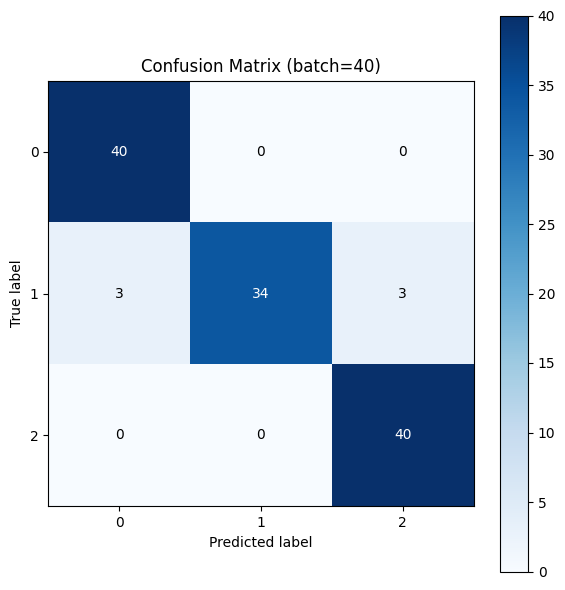

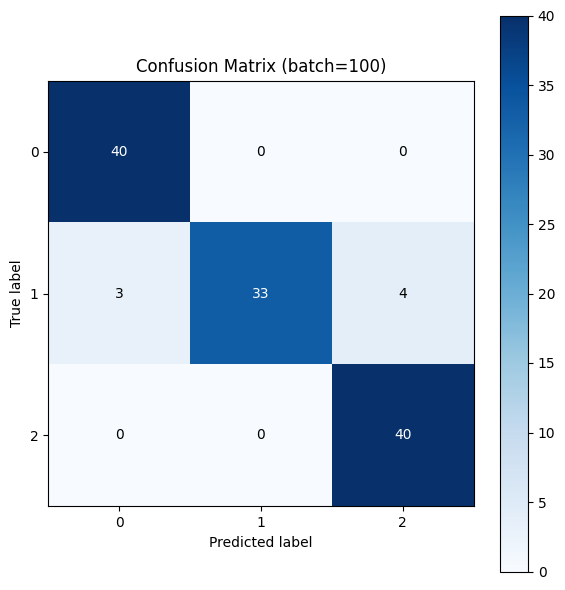

In [15]:
# Visualization
plot_results(train_accuracies, test_accuracies, times, final_confusion_matrices, batch_sizes, epochs,num_classes)